In [1]:
import numpy as np
import matplotlib.pyplot as plt

Interpolamos el $\Phi$ real en los tiempos que calculamos el $\Phi$ con SIC:

In [2]:
T_REAL_PHI_FILE = "../data/t1_pps_aligned.bin" 
REAL_PHI_FILE = "../data/real_phi.bin"
T_SIC_PHI_FILE = "../data/t1.bin"

In [3]:
t_real_phi = np.fromfile(T_REAL_PHI_FILE)
real_phi = np.fromfile(REAL_PHI_FILE)
t_sic_phi = np.fromfile(T_SIC_PHI_FILE)

real_phi = np.interp(t_sic_phi,t_real_phi,real_phi)

real_phi.tofile("../data/real_phi_interp.bin")

In [4]:
from calc_mtie import mtie_calc
import numpy as np
import matplotlib.pyplot as plt

In [5]:
MTIE_WINDOW = 60
REAL_PHI_FILE = '../data/real_phi_interp.bin'
SIC_PHI_FILE = '../data/sic_phi.bin'
T_PPS_FILE = '../data/t1.bin'

In [6]:
real_phi = np.fromfile(REAL_PHI_FILE)
sic_phi = np.fromfile(SIC_PHI_FILE)
sic_phi = np.round(sic_phi)
t_pps = np.fromfile(T_PPS_FILE)

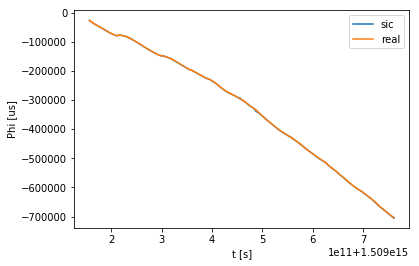

In [7]:
plt.plot(t_pps, sic_phi)
plt.plot(t_pps, real_phi)
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('sic','real'));

In [8]:
te = sic_phi - real_phi

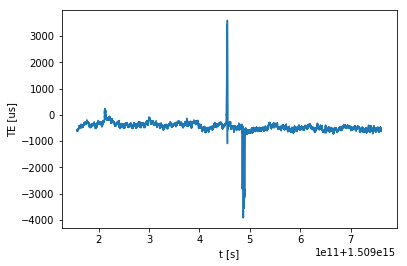

In [9]:
plt.plot(t_pps,te)
plt.xlabel('t [s]')
plt.ylabel('TE [us]');

In [10]:
tie, mtie = mtie_calc(te, MTIE_WINDOW)

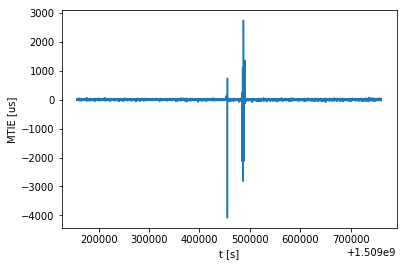

In [11]:
plt.plot(t_pps[:-MTIE_WINDOW]/1e6, tie)
plt.xlabel('t [s]')
plt.ylabel('MTIE [us]');

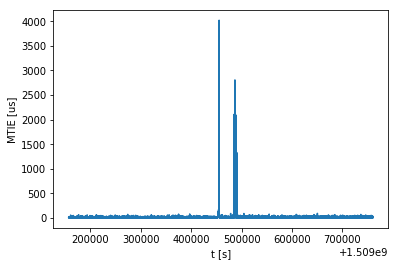

In [12]:
plt.plot(t_pps[:-MTIE_WINDOW]/1e6,mtie)
plt.xlabel('t [s]')
plt.ylabel('MTIE [us]');

Sacamos los picos, mayores a un threshold 

In [13]:
threshold = 80

In [14]:
mtie = np.clip(mtie,0,threshold)

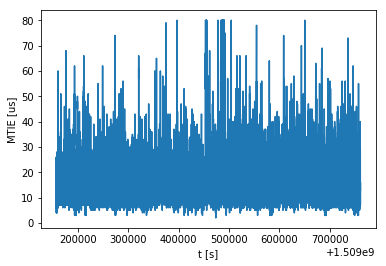

In [15]:
plt.plot(t_pps[:-MTIE_WINDOW]/1e6,mtie)
plt.xlabel('t [s]')
plt.ylabel('MTIE [us]');

In [16]:
perc = np.percentile(mtie, 90)
perc

24.999960999935865

In [17]:
np.median(mtie)

14.999609996913932

(0, 80)

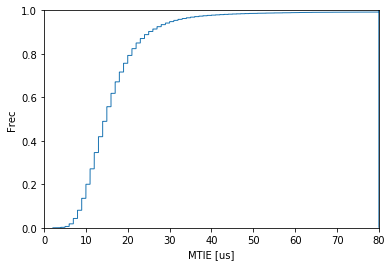

In [18]:
plt.hist(mtie, bins=5000, density=True, cumulative=True, histtype='step')
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.ylim([0,1])
plt.xlim([0, threshold])

__OTRA FORMA, SIN BINS:__

In [19]:
def histogram_no_bins(x):
    # esto nos da los valores únicos de MTIE, y cuántas veces aparece cada uno (frecuencia)
    values, frequencies = np.unique(x, return_counts = True)
    # suma acumulada
    histogram = np.cumsum(frequencies)
    histogram = histogram/histogram[-1]
    return values, histogram

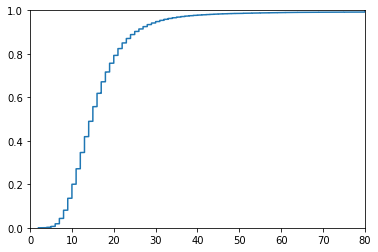

In [20]:
val, hist = histogram_no_bins(mtie)
plt.plot(val, hist)
plt.ylim([0,1])
plt.xlim([0,threshold]);

__QUEDAN ESCALONES PORQUE LOS MTIE DAN NUMEROS CASI REDONDOS!__

Para que quede "suave", podemos hacer esto:

In [21]:
def hist2(x,a,b):
    h = np.zeros(b-a+1)
    for y in x:
        h[int(np.round(y)):] += 1
    return h/h[-1]

In [22]:
max_c = int(np.max(mtie))
h2 = hist2(mtie,0,max_c)

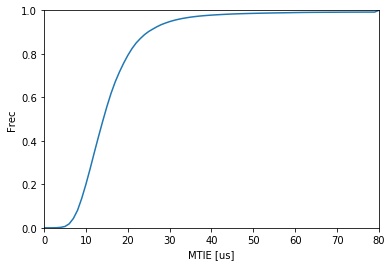

In [23]:
plt.plot(np.arange(0,max_c+1),h2)
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.ylim([0,1])
plt.xlim([0,threshold]);

Esto es más rápido y da igual:

In [24]:
def hist3(x,bins,range):
    frec, bins = np.histogram(x,bins=bins,range=range)
    frec = np.cumsum(frec)
    frec = frec/frec[-1]
    return bins[:-1],frec

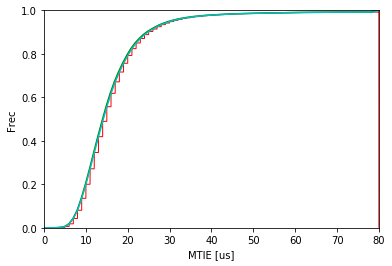

In [25]:
val, frec = hist3(mtie, threshold + 1, (0,threshold))

plt.plot(val,frec,c='g')
plt.plot(h2/h2[-1],c='c')
plt.hist(mtie, bins=5000, density=True, cumulative=True, histtype='step',color='r');
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.ylim([0,1])
plt.xlim([0,threshold]);

ZOOM:

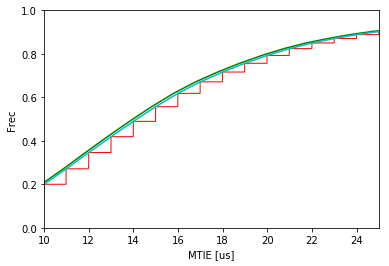

In [26]:
plt.plot(val,frec,c='g')
plt.plot(h2,c='c')
plt.hist(mtie, bins=5000, density=True, cumulative=True, histtype='step',color='r');
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.ylim([0,1])
plt.xlim([10,25]);

El celeste y el verde son casi iguales:

In [27]:
np.max(np.abs(h2 - frec))

1.4897209256126143e-05

(Nos quedamos con hist3 que es más rápido)

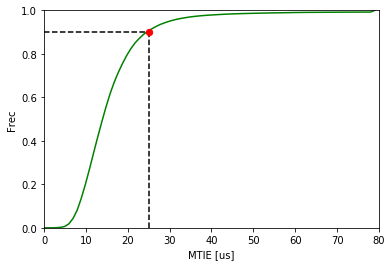

In [28]:
plt.plot(val,frec,c='g')
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.vlines(perc,0,0.90,linestyles='dashed')
plt.hlines(0.90,0,perc,linestyles='dashed')
plt.scatter([perc],[0.90],s=40,c='r',marker='o',zorder=3)
plt.ylim([0,1])
plt.xlim([0,threshold]);

__OTRA FORMA DE CALCULAR EL MTIE:VENTANAS FIJAS, COMO EN EL ORIGINAL, EN VEZ DE 1 VENTANA QUE SE DESLIZA.__

In [30]:
from calc_mtie import mtie_calc_2

tie, mtie = mtie_calc_2(te, MTIE_WINDOW)
mtie = np.clip(mtie,0,threshold)

In [32]:
val_2, frec_2 = hist3(mtie, threshold + 1, (0,threshold))

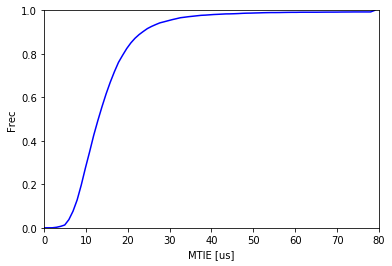

In [33]:
plt.plot(val_2,frec_2,c='b')
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.ylim([0,1])
plt.xlim([0,threshold]);

In [34]:
np.percentile(mtie,90)

23.999934199836574

In [35]:
np.median(mtie)

13.999539999407716

Da un poco mejor, pero no es tan representativo porque no recorre TODAS las ventanas de 60 segundos